In [1]:
import os
import pandas as pd
import numpy as np
import geopandas as gpd
import networkx as nx
from shapely.geometry import Point, Polygon, LineString 
import matplotlib.pyplot as plt

In [2]:
shape_folder = 'NiceMap_MckeesRocks_Rev2'

In [3]:
link_df = gpd.read_file(os.path.join(shape_folder, 'link.dbf'))
# node_df = gpd.read_file(os.path.join(shape_folder, 'node.dbf'))

In [4]:
# node_df['LL'] = node_df.apply(lambda x: str(np.round(x['LAT'], 5)) + ',' + str(np.round(x['LON'], 5)), axis = 1)
link_df['LL1'] = link_df.apply(lambda x: str(np.round(x['LAT1'], 6)) + ',' + str(np.round(x['LON1'], 6)), axis = 1)
link_df['LL2'] = link_df.apply(lambda x: str(np.round(x['LAT2'], 6)) + ',' + str(np.round(x['LON2'], 6)), axis = 1)

In [5]:
link_df[link_df['ID_1'] == 21279]

,ID_1,LENGTH,DIR,AB_SPEED,BA_SPEED,AB_CAPACIT,BA_CAPACIT,AB_DISTANC,BA_DISTANC,AB_SPDCLAS,...,BA_INTVT_2,AB_PM,BA_PM,LAT1,LON1,LAT2,LON2,geometry,LL1,LL2
11035,21279,0.08,0,35.0,35.0,775,775,96,96,44,...,1564,2,2,40.938114,-80.363434,40.927867,-80.368537,"LINESTRING (1246538.888 595300.6899999999, 124...","40.938114,-80.363434","40.927867,-80.368537"


In [6]:
node_list = list(set(link_df['LL1'].unique().tolist() + link_df['LL2'].unique().tolist()))

In [7]:
tmp_node_df = pd.DataFrame(index = range(len(node_list)), columns = ['ID', 'LAT', 'LON', 'LL'])
for i in range(len(node_list)):
    LL = node_list[i]
    LAT = np.float(LL.split(',')[0])
    LON = np.float(LL.split(',')[1])
    tmp_node_df.iloc[i] = [i, LAT, LON, LL]

In [8]:
tmp_node_df.head()

,ID,LAT,LON,LL
0,0,40.6862,-80.2697,"40.686159,-80.269728"
1,1,40.5449,-79.8384,"40.544872,-79.838449"
2,2,40.3861,-79.7572,"40.386094,-79.757154"
3,3,40.4589,-80.0312,"40.458906,-80.031227"
4,4,40.5364,-79.0654,"40.536441,-79.065447"


In [9]:
nodeLL2ID_dict = dict()
for row in tmp_node_df.itertuples():
#     print row
    ID = np.int(row[1])
    LL = row[4]
    nodeLL2ID_dict[LL] = ID

In [10]:
nodeID2LL = dict()
for row in tmp_node_df.itertuples():
    ID = np.int(row[1])
    LL = (np.float(row[3]), np.float(row[2]))
    nodeID2LL[ID] = LL

In [11]:
link_df['NODE_1'] = link_df.apply(lambda x: nodeLL2ID_dict[x['LL1']], axis = 1)
link_df['NODE_2'] = link_df.apply(lambda x: nodeLL2ID_dict[x['LL2']], axis = 1)

In [12]:
link_df['isconnector'] = link_df['AB_CAPACIT'] == 9999

In [13]:
link_df.head()

,ID_1,LENGTH,DIR,AB_SPEED,BA_SPEED,AB_CAPACIT,BA_CAPACIT,AB_DISTANC,BA_DISTANC,AB_SPDCLAS,...,LAT1,LON1,LAT2,LON2,geometry,LL1,LL2,NODE_1,NODE_2,isconnector
0,1,0.00,0,10.0,10.0,9999,9999,3,3,15,...,40.440546,-80.005426,40.439919,-80.005830,LINESTRING (1340786.260416665 411359.843749995...,"40.440546,-80.005426","40.439919,-80.00583",2152,1511,True
1,2,0.01,0,10.0,10.0,9999,9999,4,4,15,...,40.440546,-80.005426,40.440292,-80.004540,LINESTRING (1340786.260416665 411359.843749995...,"40.440546,-80.005426","40.440292,-80.00454",2152,7688,True
2,3,0.00,0,10.0,10.0,9999,9999,3,3,15,...,40.440546,-80.005426,40.441149,-80.005780,LINESTRING (1340786.260416665 411359.843749995...,"40.440546,-80.005426","40.441149,-80.00578",2152,5013,True
3,4,0.00,0,10.0,10.0,9999,9999,3,3,15,...,40.439200,-80.003018,40.438827,-80.002979,LINESTRING (1341443.708333333 410852.447916657...,"40.4392,-80.003018","40.438827,-80.002979",6974,2642,True
4,5,0.01,0,10.0,10.0,9999,9999,6,6,15,...,40.439200,-80.003018,40.439745,-80.002333,LINESTRING (1341443.708333333 410852.447916657...,"40.4392,-80.003018","40.439745,-80.002333",6974,3048,True


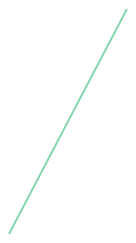

In [14]:
link_df.iloc[0]['geometry']

In [15]:
DG=nx.DiGraph()
# DG=nx.MultiDiGraph()

for i in range(len(link_df)):
    row = link_df.iloc[i]
    length = np.float(row['LENGTH'])
    ID = np.int(row['ID_1'])
    #AB side
    AB_speed = np.float(row['AB_SPEED'])
    BA_speed = np.float(row['BA_SPEED'])
    AB_lanes = np.int(row['AB_LANES'])
    BA_lanes = np.int(row['BA_LANES'])
    A_node = row['NODE_1']
    B_node = row['NODE_2']
    if not np.isclose(AB_speed, 0.0):
        DG.add_edge(A_node, B_node, linkID = ID, isOD = row['isconnector'], 
                    spd = AB_speed, l = length, lanes = AB_lanes, note = str(ID))
    if not np.isclose(BA_speed, 0.0):
        DG.add_edge(B_node, A_node, linkID = ID + 1000000, isOD = row['isconnector'], 
                    spd = BA_speed, l = length, lanes = BA_lanes, note = str(ID + 1000000))

In [16]:
# normal_node_list = list()
# for edge in DG.edges():
#     if not DG[edge[0]][edge[1]]['isOD']:
#         normal_node_list.append(edge[0])
#         normal_node_list.append(edge[1])
# normal_node_list = list(set(normal_node_list))

# OD_node_list = list()
# for node in DG.nodes():
#     if node not in normal_node_list:
#         OD_node_list.append(node)

In [17]:
noOD_node_list = list()
for edge in DG.edges():
    if not DG[edge[0]][edge[1]]['isOD']:
        noOD_node_list.append(edge[0])
        noOD_node_list.append(edge[1])
noOD_node_list = list(set(noOD_node_list))


OD_node_list = list()
near_OD_list = list()
for edge in DG.edges():
    if DG[edge[0]][edge[1]]['isOD']:
        for i in [0, 1]:
            if edge[i] not in noOD_node_list:
                OD_node_list.append(edge[i])
            else:
                near_OD_list.append(edge[i])

normal_node_list = list()
for node in DG.nodes():
    if (node not in OD_node_list) and (node not in near_OD_list):
        normal_node_list.append(node)

OD_node_list = list(set(OD_node_list))
near_OD_list = list(set(near_OD_list))
normal_node_list = list(set(normal_node_list))

In [18]:
OD_node_list

[1536,
 1537,
 8194,
 1963,
 4100,
 8364,
 3081,
 5642,
 7180,
 7170,
 4013,
 2576,
 3089,
 771,
 3093,
 2137,
 2564,
 27,
 3100,
 30,
 7713,
 547,
 1572,
 549,
 4646,
 2599,
 1576,
 3113,
 554,
 4451,
 558,
 2607,
 1584,
 5684,
 3125,
 8247,
 2104,
 2105,
 6715,
 2108,
 6923,
 8254,
 6528,
 64,
 8032,
 2115,
 7350,
 3654,
 5191,
 2633,
 586,
 4173,
 78,
 4176,
 1106,
 2643,
 2133,
 5718,
 6231,
 1625,
 2151,
 92,
 4701,
 6672,
 3515,
 4196,
 5223,
 2152,
 8297,
 871,
 1985,
 621,
 7790,
 6845,
 626,
 1654,
 1143,
 121,
 122,
 1149,
 2686,
 7807,
 4459,
 134,
 135,
 6793,
 5439,
 8045,
 6677,
 4242,
 3732,
 5486,
 5271,
 153,
 5239,
 4252,
 1695,
 4768,
 1187,
 6821,
 2215,
 4776,
 1564,
 6826,
 7340,
 6318,
 2223,
 8138,
 7112,
 3762,
 691,
 3764,
 5918,
 1206,
 8393,
 2744,
 5305,
 6331,
 1212,
 7869,
 704,
 5318,
 7367,
 3272,
 8140,
 5323,
 5836,
 5325,
 6862,
 3791,
 7376,
 1746,
 3536,
 5070,
 5334,
 6639,
 4312,
 217,
 3290,
 7388,
 4730,
 5854,
 223,
 1248,
 5328,
 738,
 2427,


In [19]:
new_DG = DG.copy()

In [20]:
def process_once(DG, OD_node_list, fake_offset = 100000):
    for node in DG.nodes():
        if (node not in OD_node_list) and (node not in near_OD_list):
            ind = DG.in_degree(node)
            outd = DG.out_degree(node)
            if ind == 0 or outd == 0:
                print "Case 1:"
                DG.remove_node(node)
                return (DG, False)
            if ind == 1 and outd == 1:
                print 'Case 2:'
                in_edge = DG.in_edges(node)[0]
                out_edge = DG.out_edges(node)[0]
                if (in_edge[0] == out_edge[1]) and (in_edge[1] == out_edge[0]):
                    DG.remove_node(node)
                    return (DG, False)
                in_ID = DG[in_edge[0]][in_edge[1]]['linkID']
                in_lanes = DG[in_edge[0]][in_edge[1]]['lanes']
                out_lanes = DG[out_edge[0]][out_edge[1]]['lanes']
                in_l = np.maximum(DG[in_edge[0]][in_edge[1]]['l'], 0.01)
                out_l = np.maximum(DG[out_edge[0]][out_edge[1]]['l'], 0.01)
                in_spd = DG[in_edge[0]][in_edge[1]]['spd']
                out_spd = DG[out_edge[0]][out_edge[1]]['spd']
                in_note = DG[in_edge[0]][in_edge[1]]['note']
                out_note = DG[out_edge[0]][out_edge[1]]['note']
#                 print DG[in_edge[0]][in_edge[1]], DG[out_edge[0]][out_edge[1]]
                agg_lanes = np.round(np.average([in_lanes, out_lanes], weights=[in_l, out_l]))
                agg_l = in_l + out_l
                agg_spd = np.average([in_spd, out_spd], weights=[in_l, out_l])
                DG.add_edge(in_edge[0], out_edge[1], linkID = in_ID, 
                            isOD = False, spd = agg_spd, l = agg_l, lanes = agg_lanes,
                            note = in_note + '+' + out_note)
                DG.remove_node(node)
                return (DG, False)
            if ind == 2 and outd ==2:
                out_edges = DG.out_edges(node)
                in_edges = DG.in_edges(node)
                tmp_nodes = list(set([out_edges[0][0], out_edges[0][1], out_edges[1][0], out_edges[1][1],
                                in_edges[0][0], in_edges[0][1], in_edges[1][0], in_edges[1][1]]))
                if len(tmp_nodes) == 3:
                    print 'Case 3', in_edges, out_edges
                    tmp_nodes.remove(node)
                    in_node = tmp_nodes[0]
                    out_node = tmp_nodes[1]
                    new_node = node + fake_offset
                    DG.add_edge(in_node, new_node, linkID = DG[in_node][node]['linkID'], isOD = False, 
                                    spd = DG[in_node][node]['spd'], l = DG[in_node][node]['l'], 
                                    lanes = DG[in_node][node]['lanes'], note = DG[in_node][node]['note'])
                    DG.add_edge(new_node, out_node, linkID = DG[node][out_node]['linkID'], isOD = False, 
                                    spd = DG[node][out_node]['spd'], l = DG[node][out_node]['l'], 
                                    lanes = DG[node][out_node]['lanes'], note = DG[node][out_node]['note'])
                    DG.remove_edge(in_node, node)
                    DG.remove_edge(node, out_node)
                    return (DG, False)
    return (DG, True)

In [21]:
new_DG = DG.copy()
flag = False
while(not flag):
    print len(new_DG.edges()), len(new_DG.nodes())
    (new_DG, flag) = process_once(new_DG, OD_node_list)

20798 8404
Case 3 [(6834, 0), (6755, 0)] [(0, 6834), (0, 6755)]
20798 8405
Case 2:
20797 8404
Case 3 [(6058, 2), (4338, 2)] [(2, 6058), (2, 4338)]
20797 8405
Case 2:
20796 8404
Case 3 [(2875, 5), (7629, 5)] [(5, 2875), (5, 7629)]
20796 8405
Case 2:
20795 8404
Case 3 [(1274, 14), (2350, 14)] [(14, 1274), (14, 2350)]
20795 8405
Case 2:
20794 8404
Case 3 [(5468, 15), (7685, 15)] [(15, 5468), (15, 7685)]
20794 8405
Case 2:
20793 8404
Case 3 [(1924, 19), (4126, 19)] [(19, 1924), (19, 4126)]
20793 8405
Case 2:
20792 8404
Case 2:
20791 8403
Case 3 [(7296, 26), (5162, 26)] [(26, 7296), (26, 5162)]
20791 8404
Case 2:
20790 8403
Case 3 [(537, 36), (6050, 36)] [(36, 537), (36, 6050)]
20790 8404
Case 2:
20789 8403
Case 3 [(1301, 38), (734, 38)] [(38, 1301), (38, 734)]
20789 8404
Case 2:
20788 8403
Case 3 [(464, 41), (8074, 41)] [(41, 464), (41, 8074)]
20788 8404
Case 2:
20787 8403
Case 3 [(1112, 46), (1569, 46)] [(46, 1112), (46, 1569)]
20787 8404
Case 2:
20786 8403
Case 3 [(7759, 49), (5871, 49)]

20696 8397
Case 2:
20695 8396
Case 3 [(1034, 363), (2999, 363)] [(363, 1034), (363, 2999)]
20695 8397
Case 2:
20694 8396
Case 3 [(6057, 368), (574, 368)] [(368, 6057), (368, 574)]
20694 8397
Case 2:
20693 8396
Case 3 [(6451, 369), (1676, 369)] [(369, 6451), (369, 1676)]
20693 8397
Case 2:
20692 8396
Case 3 [(6467, 371), (5759, 371)] [(371, 6467), (371, 5759)]
20692 8397
Case 2:
20691 8396
Case 3 [(4536, 373), (362, 373)] [(373, 4536), (373, 362)]
20691 8397
Case 2:
20690 8396
Case 3 [(7448, 377), (1405, 377)] [(377, 7448), (377, 1405)]
20690 8397
Case 2:
20689 8396
Case 3 [(7976, 381), (6911, 381)] [(381, 7976), (381, 6911)]
20689 8397
Case 2:
20688 8396
Case 3 [(7210, 388), (6203, 388)] [(388, 7210), (388, 6203)]
20688 8397
Case 2:
20687 8396
Case 3 [(864, 389), (835, 389)] [(389, 864), (389, 835)]
20687 8397
Case 2:
20686 8396
Case 3 [(1456, 390), (1132, 390)] [(390, 1456), (390, 1132)]
20686 8397
Case 2:
20685 8396
Case 3 [(4872, 401), (6792, 401)] [(401, 4872), (401, 6792)]
20685 8

20598 8393
Case 2:
20597 8392
Case 3 [(4049, 728), (7093, 728)] [(728, 4049), (728, 7093)]
20597 8393
Case 2:
20596 8392
Case 3 [(2154, 733), (3131, 733)] [(733, 2154), (733, 3131)]
20596 8393
Case 2:
20595 8392
Case 3 [(7654, 735), (1182, 735)] [(735, 7654), (735, 1182)]
20595 8393
Case 2:
20594 8392
Case 3 [(1258, 737), (679, 737)] [(737, 1258), (737, 679)]
20594 8393
Case 2:
20593 8392
Case 2:
20592 8391
Case 3 [(3960, 751), (2990, 751)] [(751, 3960), (751, 2990)]
20592 8392
Case 2:
20591 8391
Case 2:
20590 8390
Case 3 [(5603, 758), (6775, 758)] [(758, 5603), (758, 6775)]
20590 8391
Case 2:
20589 8390
Case 3 [(975, 763), (3039, 763)] [(763, 975), (763, 3039)]
20589 8391
Case 2:
20588 8390
Case 2:
20587 8389
Case 3 [(1867, 767), (1819, 767)] [(767, 1867), (767, 1819)]
20587 8390
Case 2:
20586 8389
Case 3 [(3813, 776), (2135, 776)] [(776, 3813), (776, 2135)]
20586 8390
Case 2:
20585 8389
Case 3 [(810, 777), (7398, 777)] [(777, 810), (777, 7398)]
20585 8390
Case 2:
20584 8389
Case 3 [(

20501 8385
Case 2:
20500 8384
Case 3 [(8096, 1056), (2030, 1056)] [(1056, 8096), (1056, 2030)]
20500 8385
Case 2:
20499 8384
Case 3 [(4824, 1058), (2220, 1058)] [(1058, 4824), (1058, 2220)]
20499 8385
Case 2:
20498 8384
Case 3 [(1867, 1062), (5869, 1062)] [(1062, 1867), (1062, 5869)]
20498 8385
Case 2:
20497 8384
Case 3 [(1281, 1065), (2844, 1065)] [(1065, 1281), (1065, 2844)]
20497 8385
Case 2:
20496 8384
Case 3 [(72, 1074), (353, 1074)] [(1074, 72), (1074, 353)]
20496 8385
Case 2:
20495 8384
Case 3 [(6877, 1077), (2199, 1077)] [(1077, 6877), (1077, 2199)]
20495 8385
Case 2:
20494 8384
Case 3 [(4835, 1078), (2604, 1078)] [(1078, 4835), (1078, 2604)]
20494 8385
Case 2:
20493 8384
Case 3 [(1693, 1081), (7343, 1081)] [(1081, 1693), (1081, 7343)]
20493 8385
Case 2:
20491 8384
Case 3 [(4512, 1083), (521, 1083)] [(1083, 4512), (1083, 521)]
20491 8385
Case 2:
20490 8384
Case 3 [(378, 1085), (1981, 1085)] [(1085, 378), (1085, 1981)]
20490 8385
Case 2:
20489 8384
Case 3 [(7698, 1087), (4957, 1

20402 8376
Case 3 [(8168, 1422), (7191, 1422)] [(1422, 8168), (1422, 7191)]
20402 8377
Case 2:
20401 8376
Case 3 [(2977, 1424), (2892, 1424)] [(1424, 2977), (1424, 2892)]
20401 8377
Case 2:
20400 8376
Case 3 [(5341, 1427), (2406, 1427)] [(1427, 5341), (1427, 2406)]
20400 8377
Case 2:
20399 8376
Case 3 [(8067, 1434), (669, 1434)] [(1434, 8067), (1434, 669)]
20399 8377
Case 2:
20398 8376
Case 3 [(6779, 1440), (5557, 1440)] [(1440, 6779), (1440, 5557)]
20398 8377
Case 2:
20397 8376
Case 3 [(2968, 1442), (2191, 1442)] [(1442, 2968), (1442, 2191)]
20397 8377
Case 2:
20396 8376
Case 3 [(4843, 1444), (1727, 1444)] [(1444, 4843), (1444, 1727)]
20396 8377
Case 2:
20395 8376
Case 3 [(8289, 1453), (3090, 1453)] [(1453, 8289), (1453, 3090)]
20395 8377
Case 2:
20394 8376
Case 3 [(3803, 1457), (4765, 1457)] [(1457, 3803), (1457, 4765)]
20394 8377
Case 2:
20393 8376
Case 3 [(4009, 1463), (5963, 1463)] [(1463, 4009), (1463, 5963)]
20393 8377
Case 2:
20392 8376
Case 2:
20391 8375
Case 3 [(1108, 1473), 

20306 8366
Case 2:
20305 8365
Case 3 [(5593, 1798), (4028, 1798)] [(1798, 5593), (1798, 4028)]
20305 8366
Case 2:
20304 8365
Case 3 [(5424, 1801), (3123, 1801)] [(1801, 5424), (1801, 3123)]
20304 8366
Case 2:
20303 8365
Case 3 [(1091, 1809), (6463, 1809)] [(1809, 1091), (1809, 6463)]
20303 8366
Case 2:
20302 8365
Case 3 [(2472, 1818), (5145, 1818)] [(1818, 2472), (1818, 5145)]
20302 8366
Case 2:
20301 8365
Case 3 [(6764, 1823), (6949, 1823)] [(1823, 6764), (1823, 6949)]
20301 8366
Case 2:
20300 8365
Case 3 [(4003, 1825), (6637, 1825)] [(1825, 4003), (1825, 6637)]
20300 8366
Case 2:
20299 8365
Case 3 [(7194, 1829), (1458, 1829)] [(1829, 7194), (1829, 1458)]
20299 8366
Case 2:
20298 8365
Case 3 [(7457, 1835), (5059, 1835)] [(1835, 7457), (1835, 5059)]
20298 8366
Case 2:
20297 8365
Case 3 [(2794, 1838), (2962, 1838)] [(1838, 2794), (1838, 2962)]
20297 8366
Case 2:
20296 8365
Case 3 [(3954, 1845), (1460, 1845)] [(1845, 3954), (1845, 1460)]
20296 8366
Case 2:
20295 8365
Case 3 [(7072, 1849)

20215 8362
Case 3 [(4379, 2193), (6767, 2193)] [(2193, 4379), (2193, 6767)]
20215 8363
Case 2:
20214 8362
Case 3 [(208, 2195), (7559, 2195)] [(2195, 208), (2195, 7559)]
20214 8363
Case 2:
20213 8362
Case 3 [(6796, 2201), (7164, 2201)] [(2201, 6796), (2201, 7164)]
20213 8363
Case 2:
20212 8362
Case 3 [(1992, 2204), (6299, 2204)] [(2204, 1992), (2204, 6299)]
20212 8363
Case 2:
20211 8362
Case 3 [(3428, 2209), (174, 2209)] [(2209, 3428), (2209, 174)]
20211 8363
Case 2:
20210 8362
Case 3 [(6841, 2214), (5843, 2214)] [(2214, 6841), (2214, 5843)]
20210 8363
Case 2:
20209 8362
Case 3 [(2738, 2216), (2635, 2216)] [(2216, 2738), (2216, 2635)]
20209 8363
Case 2:
20208 8362
Case 3 [(5798, 2218), (8278, 2218)] [(2218, 5798), (2218, 8278)]
20208 8363
Case 2:
20207 8362
Case 3 [(7441, 2219), (8313, 2219)] [(2219, 7441), (2219, 8313)]
20207 8363
Case 2:
20206 8362
Case 3 [(3565, 2226), (3047, 2226)] [(2226, 3565), (2226, 3047)]
20206 8363
Case 2:
20205 8362
Case 3 [(2593, 2228), (5059, 2228)] [(2228,

20117 8356
Case 2:
20116 8355
Case 3 [(6142, 2620), (2494, 2620)] [(2620, 6142), (2620, 2494)]
20116 8356
Case 2:
20115 8355
Case 3 [(2702, 2622), (5262, 2622)] [(2622, 2702), (2622, 5262)]
20115 8356
Case 2:
20114 8355
Case 3 [(6321, 2627), (3334, 2627)] [(2627, 6321), (2627, 3334)]
20114 8356
Case 2:
20113 8355
Case 3 [(1194, 2628), (996, 2628)] [(2628, 1194), (2628, 996)]
20113 8356
Case 2:
20112 8355
Case 3 [(2724, 2629), (1935, 2629)] [(2629, 2724), (2629, 1935)]
20112 8356
Case 2:
20111 8355
Case 3 [(4002, 2636), (4388, 2636)] [(2636, 4002), (2636, 4388)]
20111 8356
Case 2:
20110 8355
Case 3 [(4702, 2644), (6839, 2644)] [(2644, 4702), (2644, 6839)]
20110 8356
Case 2:
20109 8355
Case 3 [(5122, 2646), (1551, 2646)] [(2646, 5122), (2646, 1551)]
20109 8356
Case 2:
20108 8355
Case 3 [(7619, 2648), (263, 2648)] [(2648, 7619), (2648, 263)]
20108 8356
Case 2:
20107 8355
Case 2:
20106 8354
Case 3 [(2925, 2656), (5391, 2656)] [(2656, 2925), (2656, 5391)]
20106 8355
Case 2:
20104 8354
Case 

20021 8347
Case 2:
20020 8346
Case 3 [(1910, 2978), (4462, 2978)] [(2978, 1910), (2978, 4462)]
20020 8347
Case 2:
20019 8346
Case 3 [(5249, 2981), (8142, 2981)] [(2981, 5249), (2981, 8142)]
20019 8347
Case 2:
20018 8346
Case 3 [(3256, 2982), (5524, 2982)] [(2982, 3256), (2982, 5524)]
20018 8347
Case 2:
20017 8346
Case 3 [(5837, 2987), (1943, 2987)] [(2987, 5837), (2987, 1943)]
20017 8347
Case 2:
20016 8346
Case 3 [(2148, 3003), (1183, 3003)] [(3003, 2148), (3003, 1183)]
20016 8347
Case 2:
20015 8346
Case 3 [(2049, 3005), (1298, 3005)] [(3005, 2049), (3005, 1298)]
20015 8347
Case 2:
20014 8346
Case 3 [(3090, 3010), (877, 3010)] [(3010, 3090), (3010, 877)]
20014 8347
Case 2:
20013 8346
Case 3 [(6382, 3012), (5823, 3012)] [(3012, 6382), (3012, 5823)]
20013 8347
Case 2:
20012 8346
Case 3 [(4011, 3013), (2446, 3013)] [(3013, 4011), (3013, 2446)]
20012 8347
Case 2:
20011 8346
Case 3 [(1720, 3015), (4088, 3015)] [(3015, 1720), (3015, 4088)]
20011 8347
Case 2:
20010 8346
Case 3 [(2474, 3017), 

Case 3 [(595, 3391), (5750, 3391)] [(3391, 595), (3391, 5750)]
19928 8341
Case 2:
19927 8340
Case 3 [(3770, 3392), (7829, 3392)] [(3392, 3770), (3392, 7829)]
19927 8341
Case 2:
19926 8340
Case 3 [(6770, 3393), (4563, 3393)] [(3393, 6770), (3393, 4563)]
19926 8341
Case 2:
19925 8340
Case 2:
19924 8339
Case 3 [(4545, 3408), (5871, 3408)] [(3408, 4545), (3408, 5871)]
19924 8340
Case 2:
19923 8339
Case 3 [(3929, 3409), (3779, 3409)] [(3409, 3929), (3409, 3779)]
19923 8340
Case 2:
19922 8339
Case 3 [(5259, 3414), (5028, 3414)] [(3414, 5259), (3414, 5028)]
19922 8340
Case 2:
19921 8339
Case 3 [(3676, 3417), (6926, 3417)] [(3417, 3676), (3417, 6926)]
19921 8340
Case 2:
19920 8339
Case 2:
19919 8338
Case 3 [(7632, 3422), (4403, 3422)] [(3422, 7632), (3422, 4403)]
19919 8339
Case 2:
19918 8338
Case 3 [(5425, 3427), (7541, 3427)] [(3427, 5425), (3427, 7541)]
19918 8339
Case 2:
19917 8338
Case 3 [(3404, 3433), (3133, 3433)] [(3433, 3404), (3433, 3133)]
19917 8339
Case 2:
19916 8338
Case 3 [(3690,

Case 3 [(8273, 3801), (4725, 3801)] [(3801, 8273), (3801, 4725)]
19833 8331
Case 2:
19832 8330
Case 3 [(7812, 3802), (4788, 3802)] [(3802, 7812), (3802, 4788)]
19832 8331
Case 2:
19831 8330
Case 2:
19830 8329
Case 3 [(5969, 3805), (3183, 3805)] [(3805, 5969), (3805, 3183)]
19830 8330
Case 2:
19829 8329
Case 3 [(4107, 3806), (6492, 3806)] [(3806, 4107), (3806, 6492)]
19829 8330
Case 2:
19828 8329
Case 3 [(744, 3807), (6996, 3807)] [(3807, 744), (3807, 6996)]
19828 8330
Case 2:
19827 8329
Case 3 [(6274, 3812), (1428, 3812)] [(3812, 6274), (3812, 1428)]
19827 8330
Case 2:
19826 8329
Case 3 [(7299, 3818), (3334, 3818)] [(3818, 7299), (3818, 3334)]
19826 8330
Case 2:
19825 8329
Case 3 [(4470, 3819), (6991, 3819)] [(3819, 4470), (3819, 6991)]
19825 8330
Case 2:
19824 8329
Case 3 [(3040, 3821), (3328, 3821)] [(3821, 3040), (3821, 3328)]
19824 8330
Case 2:
19823 8329
Case 2:
19822 8328
Case 3 [(8381, 3822), (127, 3822)] [(3822, 8381), (3822, 127)]
19822 8329
Case 2:
19821 8328
Case 3 [(4540, 3

19719 8298
Case 3 [(7781, 4139), (766, 4139)] [(4139, 7781), (4139, 766)]
19719 8299
Case 2:
19718 8298
Case 3 [(7432, 4166), (1889, 4166)] [(4166, 7432), (4166, 1889)]
19718 8299
Case 2:
19717 8298
Case 3 [(5480, 4167), (5161, 4167)] [(4167, 5480), (4167, 5161)]
19717 8299
Case 2:
19716 8298
Case 3 [(3416, 4172), (2365, 4172)] [(4172, 3416), (4172, 2365)]
19716 8299
Case 2:
19715 8298
Case 3 [(4124, 4187), (7023, 4187)] [(4187, 4124), (4187, 7023)]
19715 8299
Case 2:
19714 8298
Case 3 [(4333, 4198), (2039, 4198)] [(4198, 4333), (4198, 2039)]
19714 8299
Case 2:
19713 8298
Case 2:
19712 8297
Case 3 [(5243, 4203), (2004, 4203)] [(4203, 5243), (4203, 2004)]
19712 8298
Case 2:
19711 8297
Case 2:
19710 8296
Case 3 [(3902, 4209), (5095, 4209)] [(4209, 3902), (4209, 5095)]
19710 8297
Case 2:
19709 8296
Case 2:
19708 8295
Case 3 [(717, 4210), (2759, 4210)] [(4210, 717), (4210, 2759)]
19708 8296
Case 2:
19707 8295
Case 3 [(8096, 4213), (4169, 4213)] [(4213, 8096), (4213, 4169)]
19707 8296
Case 

Case 3 [(7635, 4573), (2919, 4573)] [(4573, 7635), (4573, 2919)]
19612 8274
Case 2:
19611 8273
Case 3 [(6912, 4575), (4164, 4575)] [(4575, 6912), (4575, 4164)]
19611 8274
Case 2:
19610 8273
Case 3 [(4082, 4580), (462, 4580)] [(4580, 4082), (4580, 462)]
19610 8274
Case 2:
19609 8273
Case 3 [(385, 4588), (7495, 4588)] [(4588, 385), (4588, 7495)]
19609 8274
Case 2:
19608 8273
Case 2:
19607 8272
Case 3 [(3460, 4593), (4183, 4593)] [(4593, 3460), (4593, 4183)]
19607 8273
Case 2:
19606 8272
Case 3 [(1544, 4594), (8002, 4594)] [(4594, 1544), (4594, 8002)]
19606 8273
Case 2:
19605 8272
Case 3 [(1762, 4604), (1076, 4604)] [(4604, 1762), (4604, 1076)]
19605 8273
Case 2:
19604 8272
Case 3 [(5091, 4611), (3879, 4611)] [(4611, 5091), (4611, 3879)]
19604 8273
Case 2:
19603 8272
Case 3 [(7105, 4615), (174, 4615)] [(4615, 7105), (4615, 174)]
19603 8273
Case 2:
19602 8272
Case 3 [(3664, 4617), (6558, 4617)] [(4617, 3664), (4617, 6558)]
19602 8273
Case 2:
19601 8272
Case 3 [(6707, 4618), (6748, 4618)] [

Case 2:
19500 8250
Case 3 [(1546, 5081), (4245, 5081)] [(5081, 1546), (5081, 4245)]
19500 8251
Case 2:
19499 8250
Case 3 [(2232, 5097), (7630, 5097)] [(5097, 2232), (5097, 7630)]
19499 8251
Case 2:
19498 8250
Case 3 [(3994, 5103), (8294, 5103)] [(5103, 3994), (5103, 8294)]
19498 8251
Case 2:
19497 8250
Case 3 [(1646, 5106), (8310, 5106)] [(5106, 1646), (5106, 8310)]
19497 8251
Case 2:
19496 8250
Case 3 [(3284, 5108), (7615, 5108)] [(5108, 3284), (5108, 7615)]
19496 8251
Case 2:
19495 8250
Case 3 [(6417, 5113), (4925, 5113)] [(5113, 6417), (5113, 4925)]
19495 8251
Case 2:
19494 8250
Case 3 [(2593, 5114), (5892, 5114)] [(5114, 2593), (5114, 5892)]
19494 8251
Case 2:
19493 8250
Case 3 [(8024, 5120), (8276, 5120)] [(5120, 8024), (5120, 8276)]
19493 8251
Case 2:
19492 8250
Case 3 [(6080, 5121), (4726, 5121)] [(5121, 6080), (5121, 4726)]
19492 8251
Case 2:
19491 8250
Case 3 [(8252, 5126), (5533, 5126)] [(5126, 8252), (5126, 5533)]
19491 8251
Case 2:
19490 8250
Case 3 [(1276, 5127), (7430, 51

Case 3 [(6489, 5522), (7140, 5522)] [(5522, 6489), (5522, 7140)]
19407 8243
Case 2:
19406 8242
Case 3 [(2131, 5527), (6710, 5527)] [(5527, 2131), (5527, 6710)]
19406 8243
Case 2:
19405 8242
Case 3 [(2378, 5537), (7373, 5537)] [(5537, 2378), (5537, 7373)]
19405 8243
Case 2:
19404 8242
Case 3 [(128, 5539), (1073, 5539)] [(5539, 128), (5539, 1073)]
19404 8243
Case 2:
19403 8242
Case 3 [(8168, 5542), (7899, 5542)] [(5542, 8168), (5542, 7899)]
19403 8243
Case 2:
19402 8242
Case 3 [(4707, 5546), (8141, 5546)] [(5546, 4707), (5546, 8141)]
19402 8243
Case 2:
19401 8242
Case 3 [(4322, 5553), (4788, 5553)] [(5553, 4322), (5553, 4788)]
19401 8243
Case 2:
19400 8242
Case 3 [(7353, 5554), (4330, 5554)] [(5554, 7353), (5554, 4330)]
19400 8243
Case 2:
19399 8242
Case 3 [(3297, 5558), (7851, 5558)] [(5558, 3297), (5558, 7851)]
19399 8243
Case 2:
19398 8242
Case 3 [(4640, 5561), (2958, 5561)] [(5561, 4640), (5561, 2958)]
19398 8243
Case 2:
19397 8242
Case 3 [(7483, 5562), (5731, 5562)] [(5562, 7483), (

Case 2:
19303 8223
Case 3 [(5123, 6047), (2630, 6047)] [(6047, 5123), (6047, 2630)]
19303 8224
Case 2:
19302 8223
Case 3 [(1162, 6048), (595, 6048)] [(6048, 1162), (6048, 595)]
19302 8224
Case 2:
19301 8223
Case 3 [(6854, 6051), (3055, 6051)] [(6051, 6854), (6051, 3055)]
19301 8224
Case 2:
19300 8223
Case 3 [(1813, 6060), (7774, 6060)] [(6060, 1813), (6060, 7774)]
19300 8224
Case 2:
19299 8223
Case 2:
19298 8222
Case 2:
19297 8221
Case 3 [(3299, 6070), (6071, 6070)] [(6070, 3299), (6070, 6071)]
19297 8222
Case 2:
19296 8221
Case 3 [(6996, 6074), (7135, 6074)] [(6074, 6996), (6074, 7135)]
19296 8222
Case 2:
19295 8221
Case 3 [(889, 6076), (8075, 6076)] [(6076, 889), (6076, 8075)]
19295 8222
Case 2:
19294 8221
Case 3 [(6172, 6077), (7341, 6077)] [(6077, 6172), (6077, 7341)]
19294 8222
Case 2:
19293 8221
Case 3 [(2404, 6087), (4380, 6087)] [(6087, 2404), (6087, 4380)]
19293 8222
Case 2:
19292 8221
Case 3 [(7977, 6088), (1244, 6088)] [(6088, 7977), (6088, 1244)]
19292 8222
Case 2:
19291 82

19200 8208
Case 2:
19199 8207
Case 2:
19198 8206
Case 3 [(277, 6625), (3046, 6625)] [(6625, 277), (6625, 3046)]
19198 8207
Case 2:
19197 8206
Case 3 [(5928, 6626), (7201, 6626)] [(6626, 5928), (6626, 7201)]
19197 8207
Case 2:
19196 8206
Case 3 [(4368, 6628), (426, 6628)] [(6628, 4368), (6628, 426)]
19196 8207
Case 2:
19195 8206
Case 3 [(5675, 6630), (5821, 6630)] [(6630, 5675), (6630, 5821)]
19195 8207
Case 2:
19194 8206
Case 3 [(4120, 6631), (2462, 6631)] [(6631, 4120), (6631, 2462)]
19194 8207
Case 2:
19193 8206
Case 3 [(6614, 6642), (2855, 6642)] [(6642, 6614), (6642, 2855)]
19193 8207
Case 2:
19192 8206
Case 3 [(3297, 6650), (6797, 6650)] [(6650, 3297), (6650, 6797)]
19192 8207
Case 2:
19191 8206
Case 3 [(4705, 6655), (6622, 6655)] [(6655, 4705), (6655, 6622)]
19191 8207
Case 2:
19190 8206
Case 3 [(2537, 6658), (3869, 6658)] [(6658, 2537), (6658, 3869)]
19190 8207
Case 2:
19189 8206
Case 3 [(7985, 6659), (731, 6659)] [(6659, 7985), (6659, 731)]
19189 8207
Case 2:
19188 8206
Case 3 

19089 8192
Case 2:
19088 8191
Case 3 [(6337, 7183), (4723, 7183)] [(7183, 6337), (7183, 4723)]
19088 8192
Case 2:
19087 8191
Case 3 [(7428, 7184), (7302, 7184)] [(7184, 7428), (7184, 7302)]
19087 8192
Case 2:
19086 8191
Case 3 [(7504, 7195), (4726, 7195)] [(7195, 7504), (7195, 4726)]
19086 8192
Case 2:
19085 8191
Case 3 [(5386, 7197), (3372, 7197)] [(7197, 5386), (7197, 3372)]
19085 8192
Case 2:
19084 8191
Case 3 [(3668, 7199), (3903, 7199)] [(7199, 3668), (7199, 3903)]
19084 8192
Case 2:
19083 8191
Case 3 [(1675, 7204), (4054, 7204)] [(7204, 1675), (7204, 4054)]
19083 8192
Case 2:
19082 8191
Case 3 [(409, 7207), (6575, 7207)] [(7207, 409), (7207, 6575)]
19082 8192
Case 2:
19081 8191
Case 3 [(5451, 7226), (5199, 7226)] [(7226, 5451), (7226, 5199)]
19081 8192
Case 2:
19080 8191
Case 3 [(7427, 7227), (4587, 7227)] [(7227, 7427), (7227, 4587)]
19080 8192
Case 2:
19079 8191
Case 3 [(5571, 7242), (2351, 7242)] [(7242, 5571), (7242, 2351)]
19079 8192
Case 2:
19078 8191
Case 3 [(161, 7249), (

Case 2:
18966 8177
Case 3 [(5393, 7818), (3985, 7818)] [(7818, 5393), (7818, 3985)]
18966 8178
Case 2:
18965 8177
Case 3 [(6195, 7822), (6588, 7822)] [(7822, 6195), (7822, 6588)]
18965 8178
Case 2:
18964 8177
Case 3 [(4264, 7823), (7716, 7823)] [(7823, 4264), (7823, 7716)]
18964 8178
Case 2:
18963 8177
Case 3 [(6489, 7828), (4873, 7828)] [(7828, 6489), (7828, 4873)]
18963 8178
Case 2:
18962 8177
Case 3 [(6064, 7832), (132, 7832)] [(7832, 6064), (7832, 132)]
18962 8178
Case 2:
18961 8177
Case 3 [(4929, 7833), (5750, 7833)] [(7833, 4929), (7833, 5750)]
18961 8178
Case 2:
18960 8177
Case 3 [(3865, 7842), (7602, 7842)] [(7842, 3865), (7842, 7602)]
18960 8178
Case 2:
18959 8177
Case 3 [(6073, 7843), (6666, 7843)] [(7843, 6073), (7843, 6666)]
18959 8178
Case 2:
18958 8177
Case 3 [(3065, 7844), (4091, 7844)] [(7844, 3065), (7844, 4091)]
18958 8178
Case 2:
18957 8177
Case 3 [(3826, 7852), (6171, 7852)] [(7852, 3826), (7852, 6171)]
18957 8178
Case 2:
18956 8177
Case 3 [(3045, 7860), (6366, 7860

18856 8168
Case 2:
18855 8167
Case 3 [(5401, 8399), (4223, 8399)] [(8399, 5401), (8399, 4223)]
18855 8168
Case 2:
18854 8167
Case 2:
18853 8166
Case 2:
18852 8165
Case 2:
18851 8164
Case 2:
18850 8163
Case 2:
18849 8162
Case 3 [(3545, 7707), (375, 7707)] [(7707, 3545), (7707, 375)]
18849 8163
Case 2:
18848 8162
Case 2:
18847 8161
Case 3 [(1580, 7177), (7778, 7177)] [(7177, 7778), (7177, 1580)]
18847 8162
Case 2:
18846 8161
Case 2:
18845 8160
Case 3 [(3418, 6968), (6189, 6968)] [(6968, 3418), (6968, 6189)]
18845 8161
Case 2:
18844 8160
Case 2:
18843 8159
Case 3 [(4695, 7053), (491, 7053)] [(7053, 4695), (7053, 491)]
18843 8160
Case 2:
18842 8159
Case 2:
18841 8158
Case 2:
18840 8157
Case 2:
18839 8156
Case 2:
18838 8155
Case 2:
18837 8154
Case 2:
18836 8153
Case 2:
18835 8152
Case 2:
18834 8151
Case 2:
18833 8150
Case 2:
18832 8149
Case 3 [(4056, 8069), (6588, 8069)] [(8069, 4056), (8069, 6588)]
18832 8150
Case 2:
18831 8149
Case 2:
18830 8148
Case 2:
18829 8147
Case 2:
18828 8146
Case 

18509 7847
Case 2:
18508 7846
Case 2:
18507 7845
Case 2:
18506 7844
Case 2:
18505 7843
Case 2:
18504 7842
Case 2:
18503 7841
Case 2:
18502 7840
Case 2:
18501 7839
Case 2:
18500 7838
Case 2:
18499 7837
Case 2:
18498 7836
Case 3 [(3629, 7436), (8063, 7436)] [(7436, 8063), (7436, 3629)]
18498 7837
Case 2:
18497 7836
Case 2:
18496 7835
Case 2:
18495 7834
Case 2:
18494 7833
Case 2:
18493 7832
Case 2:
18492 7831
Case 2:
18491 7830
Case 2:
18490 7829
Case 2:
18489 7828
Case 2:
18488 7827
Case 2:
18487 7826
Case 2:
18486 7825
Case 2:
18485 7824
Case 2:
18484 7823
Case 2:
18483 7822
Case 2:
18482 7821
Case 2:
18481 7820
Case 2:
18480 7819
Case 2:
18479 7818
Case 2:
18478 7817
Case 2:
18477 7816
Case 2:
18476 7815
Case 2:
18475 7814
Case 2:
18474 7813
Case 2:
18473 7812
Case 3 [(7048, 4090), (3097, 4090)] [(4090, 7048), (4090, 3097)]
18473 7813
Case 2:
18472 7812
Case 2:
18471 7811
Case 2:
18470 7810
Case 2:
18469 7809
Case 2:
18468 7808
Case 2:
18467 7807
Case 2:
18466 7806
Case 2:
18465 7805
C

18260 7645
Case 3 [(5731, 8201), (2958, 8201)] [(8201, 5731), (8201, 2958)]
18260 7646
Case 2:
18259 7645
Case 2:
18258 7644
Case 2:
18257 7643
Case 2:
18256 7642
Case 2:
18255 7641
Case 2:
18254 7640
Case 3 [(1113, 4925), (6417, 4925)] [(4925, 6417), (4925, 1113)]
18254 7641
Case 2:
18253 7640
Case 2:
18252 7639
Case 2:
18251 7638
Case 2:
18250 7637
Case 2:
18249 7636
Case 2:
18248 7635
Case 2:
18247 7634
Case 2:
18246 7633
Case 2:
18245 7632
Case 3 [(5672, 7717), (5059, 7717)] [(7717, 5672), (7717, 5059)]
18245 7633
Case 2:
18244 7632
Case 2:
18243 7631
Case 2:
18242 7630
Case 2:
18241 7629
Case 2:
18240 7628
Case 2:
18239 7627
Case 2:
18238 7626
Case 3 [(602, 1925), (4279, 1925)] [(1925, 602), (1925, 4279)]
18238 7627
Case 2:
18237 7626
Case 2:
18236 7625
Case 2:
18235 7624
Case 2:
18234 7623
Case 2:
18233 7622
Case 3 [(7496, 5185), (5985, 5185)] [(5185, 7496), (5185, 5985)]
18233 7623
Case 2:
18232 7622
Case 2:
18231 7621
Case 2:
18230 7620
Case 2:
18229 7619
Case 2:
18228 7618
Cas

17953 7393
Case 2:
17952 7392
Case 2:
17951 7391
Case 2:
17950 7390
Case 2:
17949 7389
Case 2:
17948 7388
Case 2:
17947 7387
Case 3 [(1279, 6243), (2631, 6243)] [(6243, 1279), (6243, 2631)]
17947 7388
Case 2:
17946 7387
Case 2:
17945 7386
Case 2:
17944 7385
Case 2:
17943 7384
Case 3 [(7840, 7531), (5543, 7531)] [(7531, 7840), (7531, 5543)]
17943 7385
Case 2:
17942 7384
Case 2:
17941 7383
Case 2:
17940 7382
Case 3 [(2500, 8252), (5533, 8252)] [(8252, 2500), (8252, 5533)]
17940 7383
Case 2:
17939 7382
Case 2:
17938 7381
Case 2:
17937 7380
Case 2:
17936 7379
Case 2:
17935 7378
Case 2:
17934 7377
Case 3 [(2384, 1883), (5719, 1883)] [(1883, 2384), (1883, 5719)]
17934 7378
Case 2:
17933 7377
Case 2:
17932 7376
Case 2:
17931 7375
Case 3 [(3119, 2255), (6466, 2255)] [(2255, 6466), (2255, 3119)]
17931 7376
Case 2:
17930 7375
Case 2:
17929 7374
Case 2:
17928 7373
Case 3 [(2624, 2383), (149, 2383)] [(2383, 2624), (2383, 149)]
17928 7374
Case 2:
17927 7373
Case 2:
17926 7372
Case 3 [(7254, 1824), 

17707 7194
Case 2:
17706 7193
Case 2:
17705 7192
Case 2:
17704 7191
Case 3 [(1523, 6678), (6182, 6678)] [(6678, 1523), (6678, 6182)]
17704 7192
Case 2:
17703 7191
Case 2:
17702 7190
Case 2:
17701 7189
Case 2:
17700 7188
Case 3 [(171, 2398), (4581, 2398)] [(2398, 171), (2398, 4581)]
17700 7189
Case 2:
17699 7188
Case 2:
17698 7187
Case 3 [(8042, 7214), (5719, 7214)] [(7214, 5719), (7214, 8042)]
17698 7188
Case 2:
17697 7187
Case 2:
17696 7186
Case 2:
17695 7185
Case 2:
17694 7184
Case 3 [(3032, 5909), (7646, 5909)] [(5909, 3032), (5909, 7646)]
17694 7185
Case 2:
17693 7184
Case 2:
17692 7183
Case 2:
17691 7182
Case 3 [(4864, 2792), (4500, 2792)] [(2792, 4864), (2792, 4500)]
17691 7183
Case 2:
17690 7182
Case 2:
17689 7181
Case 2:
17688 7180
Case 3 [(4003, 4055), (5054, 4055)] [(4055, 4003), (4055, 5054)]
17688 7181
Case 2:
17687 7180
Case 2:
17686 7179
Case 2:
17685 7178
Case 2:
17684 7177
Case 3 [(5939, 4633), (845, 4633)] [(4633, 5939), (4633, 845)]
17684 7178
Case 2:
17683 7177
Case 

17451 6988
Case 2:
17450 6987
Case 2:
17449 6986
Case 2:
17448 6985
Case 3 [(1326, 2968), (2191, 2968)] [(2968, 1326), (2968, 2191)]
17448 6986
Case 2:
17447 6985
Case 2:
17446 6984
Case 2:
17445 6983
Case 2:
17444 6982
Case 2:
17443 6981
Case 2:
17442 6980
Case 2:
17441 6979
Case 2:
17440 6978
Case 2:
17439 6977
Case 3 [(530, 5851), (7441, 5851)] [(5851, 530), (5851, 7441)]
17439 6978
Case 2:
17438 6977
Case 2:
17437 6976
Case 2:
17436 6975
Case 2:
17435 6974
Case 2:
17434 6973
Case 3 [(1935, 3601), (4940, 3601)] [(3601, 4940), (3601, 1935)]
17434 6974
Case 2:
17433 6973
Case 2:
17432 6972
Case 2:
17431 6971
Case 2:
17430 6970
Case 2:
17429 6969
Case 3 [(1816, 4712), (4365, 4712)] [(4712, 1816), (4712, 4365)]
17429 6970
Case 2:
17428 6969
Case 2:
17427 6968
Case 2:
17426 6967
Case 3 [(480, 1858), (5109, 1858)] [(1858, 480), (1858, 5109)]
17426 6968
Case 2:
17425 6967
Case 2:
17424 6966
Case 2:
17423 6965
Case 2:
17422 6964
Case 2:
17421 6963
Case 2:
17420 6962
Case 2:
17419 6961
Case 

17205 6794
Case 2:
17204 6793
Case 3 [(308, 4246), (3902, 4246)] [(4246, 308), (4246, 3902)]
17204 6794
Case 2:
17203 6793
Case 2:
17202 6792
Case 2:
17201 6791
Case 2:
17200 6790
Case 2:
17199 6789
Case 2:
17198 6788
Case 2:
17197 6787
Case 2:
17196 6786
Case 3 [(786, 3394), (7427, 3394)] [(3394, 7427), (3394, 786)]
17196 6787
Case 2:
17195 6786
Case 2:
17194 6785
Case 2:
17193 6784
Case 2:
17192 6783
Case 3 [(4536, 7612), (7899, 7612)] [(7612, 4536), (7612, 7899)]
17192 6784
Case 2:
17191 6783
Case 2:
17190 6782
Case 2:
17189 6781
Case 2:
17188 6780
Case 2:
17187 6779
Case 2:
17186 6778
Case 2:
17185 6777
Case 3 [(3953, 6975), (2146, 6975)] [(6975, 3953), (6975, 2146)]
17185 6778
Case 2:
17184 6777
Case 2:
17183 6776
Case 2:
17182 6775
Case 2:
17181 6774
Case 2:
17180 6773
Case 3 [(6292, 5596), (7535, 5596)] [(5596, 6292), (5596, 7535)]
17180 6774
Case 2:
17179 6773
Case 2:
17178 6772
Case 2:
17177 6771
Case 2:
17176 6770
Case 2:
17175 6769
Case 2:
17174 6768
Case 3 [(5623, 4743), (1

16953 6592
Case 2:
16952 6591
Case 3 [(3359, 4372), (4365, 4372)] [(4372, 3359), (4372, 4365)]
16952 6592
Case 2:
16951 6591
Case 2:
16950 6590
Case 2:
16949 6589
Case 3 [(7321, 7030), (6967, 7030)] [(7030, 7321), (7030, 6967)]
16949 6590
Case 2:
16948 6589
Case 2:
16947 6588
Case 2:
16946 6587
Case 2:
16945 6586
Case 2:
16944 6585
Case 3 [(4843, 870), (4540, 870)] [(870, 4843), (870, 4540)]
16944 6586
Case 2:
16943 6585
Case 2:
16942 6584
Case 2:
16941 6583
Case 3 [(4890, 7669), (247, 7669)] [(7669, 4890), (7669, 247)]
16941 6584
Case 2:
16940 6583
Case 2:
16939 6582
Case 2:
16938 6581
Case 2:
16937 6580
Case 2:
16936 6579
Case 2:
16935 6578
Case 2:
16934 6577
Case 3 [(2016, 3888), (6291, 3888)] [(3888, 2016), (3888, 6291)]
16934 6578
Case 2:
16933 6577
Case 2:
16932 6576
Case 2:
16931 6575
Case 2:
16930 6574
Case 3 [(6558, 6982), (2023, 6982)] [(6982, 2023), (6982, 6558)]
16930 6575
Case 2:
16929 6574
Case 2:
16928 6573
Case 2:
16927 6572
Case 3 [(6085, 6163), (6183, 6163)] [(6163, 6

Case 2:
16708 6402
Case 2:
16707 6401
Case 2:
16706 6400
Case 2:
16705 6399
Case 2:
16704 6398
Case 2:
16703 6397
Case 2:
16702 6396
Case 2:
16701 6395
Case 3 [(5547, 5786), (4893, 5786)] [(5786, 5547), (5786, 4893)]
16701 6396
Case 2:
16700 6395
Case 2:
16699 6394
Case 2:
16698 6393
Case 2:
16697 6392
Case 3 [(6356, 5743), (1294, 5743)] [(5743, 6356), (5743, 1294)]
16697 6393
Case 2:
16696 6392
Case 2:
16695 6391
Case 2:
16694 6390
Case 3 [(3266, 7171), (5322, 7171)] [(7171, 3266), (7171, 5322)]
16694 6391
Case 2:
16693 6390
Case 2:
16692 6389
Case 2:
16691 6388
Case 2:
16690 6387
Case 3 [(7859, 4829), (2652, 4829)] [(4829, 7859), (4829, 2652)]
16690 6388
Case 2:
16689 6387
Case 2:
16688 6386
Case 2:
16687 6385
Case 2:
16686 6384
Case 2:
16685 6383
Case 2:
16684 6382
Case 2:
16683 6381
Case 3 [(4108, 5753), (3053, 5753)] [(5753, 4108), (5753, 3053)]
16683 6382
Case 2:
16682 6381
Case 2:
16681 6380
Case 2:
16680 6379
Case 2:
16679 6378
Case 2:
16678 6377
Case 2:
16677 6376
Case 3 [(726

Case 3 [(6740, 8376), (8277, 8376)] [(8376, 6740), (8376, 8277)]
16443 6188
Case 2:
16442 6187
Case 2:
16441 6186
Case 2:
16440 6185
Case 2:
16439 6184
Case 2:
16438 6183
Case 2:
16437 6182
Case 2:
16436 6181
Case 2:
16435 6180
Case 3 [(7715, 5514), (364, 5514)] [(5514, 7715), (5514, 364)]
16435 6181
Case 2:
16434 6180
Case 2:
16433 6179
Case 2:
16432 6178
Case 2:
16431 6177
Case 3 [(2232, 8178), (1082, 8178)] [(8178, 2232), (8178, 1082)]
16431 6178
Case 2:
16430 6177
Case 2:
16429 6176
Case 2:
16428 6175
Case 2:
16427 6174
Case 3 [(7037, 5041), (6814, 5041)] [(5041, 7037), (5041, 6814)]
16427 6175
Case 2:
16426 6174
Case 2:
16425 6173
Case 3 [(7353, 6814), (7037, 6814)] [(6814, 7353), (6814, 7037)]
16425 6174
Case 2:
16424 6173
Case 2:
16423 6172
Case 2:
16422 6171
Case 2:
16421 6170
Case 2:
16420 6169
Case 2:
16419 6168
Case 2:
16418 6167
Case 3 [(2520, 4529), (1441, 4529)] [(4529, 2520), (4529, 1441)]
16418 6168
Case 2:
16417 6167
Case 2:
16416 6166
Case 2:
16415 6165
Case 2:
16414 

In [22]:
def combine_linestring(note, link_df, link_offset = 1000000):
    link_list = np.array(note.split('+')).astype(np.int)
    geo_list = list()
    for linkid in link_list:
        if linkid > link_offset:
            tmp_node_list = list(reversed(list(link_df[link_df['ID_1'] == linkid - link_offset]['geometry'].values[0].coords)))
        else:
            tmp_node_list = list(link_df[link_df['ID_1'] == linkid]['geometry'].values[0].coords)
        geo_list.append(tmp_node_list)
    coor_list = list()
    for i, geo in enumerate(geo_list):
        if i == 0:
            for point in geo:
                coor_list.append(point)
        elif i == len(geo_list) - 1:
            if len(geo) == 1:
                coor_list.append(geo[0])
            else:
                for point in geo[1:]:
                    coor_list.append(point)
        else:
            if len(geo) > 1:
                for point in geo[1:]:
                    coor_list.append(point)
    return LineString(coor_list)

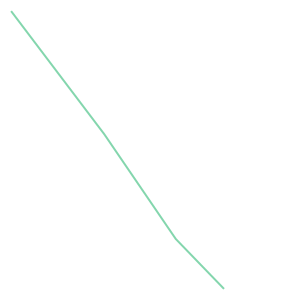

In [23]:
combine_linestring('1009695+9696+9841', link_df)

In [24]:
new_link_df = pd.DataFrame(index = range(len(new_DG.edges())), 
                        columns = ['linkID', 'N1', 'N2', 'spd', 'lanes', 'l', 'isOD', 'note'])

geo_list = list()
for i, edge in enumerate(new_DG.edges()):
    att = new_DG[edge[0]][edge[1]]
    new_link_df.iloc[i] = [att['linkID'], edge[0], edge[1], att['spd'], att['lanes'],  att['l'], 
                               np.int(att['isOD']), att['note']]
#     geo_list.append(LineString([nodeID2LL[edge[0]], nodeID2LL[edge[1]]]))
    geo_list.append(combine_linestring(att['note'], link_df))
#     break


In [25]:
# crs = {'init': 'epsg:4326'}
crs = {'init': 'epsg:3365'}
gdf = gpd.GeoDataFrame(new_link_df, crs = crs, geometry=geo_list)

In [26]:
gdf.to_file(driver = 'ESRI Shapefile', filename= "new_link.shp")

In [27]:
node_df = pd.DataFrame(index = range(len(new_DG.nodes())), columns = ['ID', 'isOD'])
geo_list = list()
crs = {'init': 'epsg:4326'}
for i in range(len(new_DG.nodes())):
    node = new_DG.nodes()[i]
    node_df.iloc[i] = [node, np.int(node in OD_node_list)]
    geo_list.append(Point(nodeID2LL[node]))
crs = {'init': 'epsg:4326'}
node_df = gpd.GeoDataFrame(node_df, crs = crs, geometry = geo_list)

In [28]:
node_df.to_file(driver = 'ESRI Shapefile', filename= "new_node.shp")

In [ ]:
new_DG[6555]